In [213]:
import pandas as pd 
import numpy as np
from pandas_datareader import data, wb
import pandas_datareader as pdr
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
import math
import stock_cache # local module
fdr.__version__

MOMENTUM_DAYS = 180 # 6개월

now = datetime.datetime.now()
start_time = datetime.datetime(2020, 1, 1, 9, 0, 0)
end_time = datetime.datetime(2021, 9, 5, 9, 0, 0)
#EST = datetime.timezone(datetime.timedelta(hours=-5))
#start_time = datetime.datetime(2020, 1, 1, 9, 0, 0, tzinfo=EST)
#start_time = datetime.datetime.strptime("20200101", "%Y%m%d")
#end_time = datetime.datetime.strptime("20210101", "%Y%m%d")
#start_time = now - datetime.timedelta(weeks=52) # 1년 전으로 start 설정
#end_time = now - datetime.timedelta(weeks=4) # 1달 전으로 end 설정

# 테스트 코드

## Dictionary append

In [214]:
ticker_dict = { }
ticker_dict["005930.KS"] = { "code": "005930.KS", "name": "Samsung"}
for k, v in ticker_dict.items():
    k = code
    print(k, v)

005930.KS {'code': '005930.KS', 'name': 'Samsung'}


## DataFrame append

In [215]:
dates = pd.date_range("20130101", periods=6)
print(type(dates[0]))
df = pd.DataFrame(columns=['A', 'B'])
for i in range(5):
    df = df.append(pd.Series({'A':i, 'B':i}, index=df.columns, name=dates[i]))
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,A,B
2013-01-01,0,0
2013-01-02,1,1
2013-01-03,2,2
2013-01-04,3,3
2013-01-05,4,4


# 종목 정보 가져오기

In [216]:
std_dict = { 
    "KS11": { "stock_name": "KOSPI" },
    "KS200": { "stock_name": "KOSPI200" }
}
system_dict = {
}

In [217]:
ticker_dict_10 = {
    "005930.KS": { "stock_name": "Samsung"},
    "000660.KS": { "stock_name": "SK Hynix"},
    "051910.KS": { "stock_name": "LG화학"},
    "068270.KS": { "stock_name": "셀트리온"},
    "035420.KS": { "stock_name": "Naver"},
    "006400.KS": { "stock_name": "Samsung SDI"},
    "005380.KS": { "stock_name": "Hyundai"},
    "035720.KS": { "stock_name": "Kakao"},
    "036570.KS": { "stock_name": "NCsoft"},
    "051900.KS": { "stock_name": "LG생활건강"}
}
#ticker_dict = ticker_dict_10.copy()
#del ticker_dict['005930.KS']
#ticker_dict = ticker_dict_10

ticker_exclude_list = []
#ticker_exclude_list = ["105560.KS"] # KB금융 - 2020-04-02 부터 3만원대 -> 3백만원대 -> 파라미터로 전달하지 않더라도 verify 코드에서 걸러냄
ticker_dict = stock_cache.get_stock_listing_dict(1000, ticker_exclude_list) # 갯수 만큼 KOSPI 종목 리스트 가져오기
print(len(ticker_dict))

817


In [218]:
# DataFrame
#def get_rate_of_return(x):
#    return round((x.iloc[-1]-x.iloc[0]),2)

def add_relative_value(ticker_data, src_name):
    # 100기준 종가 컬럼 추가
    ticker_data['relative_value'] = ticker_data[src_name] / ticker_data[src_name].iloc[0]*100

def verify_ticker_data(ticker_data):
    # 전일 대비 30% 이상 상승/하락시 에러
    result_filter = abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30
    result_data = ticker_data[result_filter]
    #result_data = ticker_data[abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30]

    if (len(result_data) > 0):
        return False
    return True
    
def get_ticker_data(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    # 이전 180일 데이터 조회, 타겟 기간 데이터 조회
    prev_data = stock_cache.get_stock_data_second_half(code, prev_start_time, prev_end_time, use_fdr)
    prev_len = len(prev_data)
    if (prev_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print("get_ticker_data(): ticker_data not enough", "prev_len)=", prev_len)
        return pd.DataFrame()
    ticker_data = stock_cache.get_stock_data(code, start_time, end_time, use_fdr)
    ticker_len = len(ticker_data)
    if (ticker_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print("get_ticker_data(): ticker_data not enough", "ticker_len=", ticker_len)
        return pd.DataFrame()
    total_data = pd.concat([prev_data, ticker_data])

    # 1일전 종가 컬럼 추가, 180일전 종가/수익률 컬럼 추가
    start_loc = len(prev_data)-1
    prev_data01 = total_data[start_loc:start_loc+len(ticker_data)]
    prev_data180 = total_data[:len(ticker_data)]
    ticker_data['prev_close01'] = prev_data01['Close'].values
    ticker_data['prev_close180'] = prev_data180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 100기준 종가 컬럼 추가
    add_relative_value(ticker_data, 'Close')
    #ticker_data['relative_close'] = ticker_data['Close'] / ticker_data['Close'].iloc[0]*100
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[prev_len:]
    ticker_data['ma25'] = ma25[prev_len:]
    ticker_data['ma50'] = ma50[prev_len:]
    ticker_data['ma100'] = ma100[prev_len:]
    
    # ATR(Average Trace Range) 추가
    tr = total_data['High'] - total_data['Low']
    ticker_data['tr'] = tr[prev_len:]
    atr20 = tr.rolling(window=20).mean()
    ticker_data['atr20'] = atr20[prev_len:]
    
    # ATA(Average Trading Amount-총거래액) 추가
    ta = total_data['Close'] * total_data['Volume']
    ticker_data['ta'] = ta[prev_len:]
    ata20 = ta.rolling(window=20).mean()
    ticker_data['ata20'] = ata20[prev_len:]
    
    if (not verify_ticker_data(ticker_data)):
        print("get_ticker_data(): verify failed", "code=", code)
        return pd.DataFrame()
    return ticker_data

# cache 이용하지 않고 직접 호출(미사용이며 참고용)
def get_ticker_data_direct(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    if (use_fdr):
        prev_data = fdr.DataReader(code, prev_start_time, prev_end_time)
        ticker_data = fdr.DataReader(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])
    else:
        prev_data = pdr.data.get_data_yahoo(code, prev_start_time, prev_end_time)
        ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])

    # 180일전 종가 컬럼, 180일전 대비 수익율 컬럼 추가
    prev_close180 = total_data[:len(ticker_data)]
    ticker_data['prev_close180'] = prev_close180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 100기준 종가 컬럼 추가
    add_relative_value(ticker_data, 'Close')
    #ticker_data['relative_close'] = ticker_data['Close'] / ticker_data['Close'].iloc[0]*100
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[len(prev_data):]
    ticker_data['ma25'] = ma25[len(prev_data):]
    ticker_data['ma50'] = ma50[len(prev_data):]
    ticker_data['ma100'] = ma100[len(prev_data):]
    return ticker_data

def load_std_dict(std_dict, year):
    start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
    end_time = datetime.datetime(year, 12, 31, 9, 0, 0)
    for k, v in std_dict.items():
        code = k
        std_dict[code]['data'] = get_ticker_data(code, start_time, end_time, use_fdr=True)

def load_ticker_dict(ticker_dict, year):
    start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
    end_time = datetime.datetime(year, 12, 31, 9, 0, 0)    
    for k in list(ticker_dict.keys()): # list 없으면 에러 발생 - dictionary changed size during iteration
        code = k
        stock_name = ticker_dict[code]['stock_name']
        ticker_data = get_ticker_data(code, start_time, end_time)
        ticker_dict[code]['data'] = ticker_data
        if (len(ticker_data) <= 0):
            print("ticker_data not enough, remove:", "code=", code, "stock_name=", stock_name)
            del ticker_dict[code]

# 차트
def show_chart():
    fig = plt.figure(figsize=(10,5))
    fig.tight_layout()
    subplot = fig.add_subplot(1,1,1)

    for k, v in std_dict.items():
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()

    for k, v in ticker_dict.items():
        if (k in ["005930.KS"]):
            name = v['stock_name']
            ticker_data = v['data']
            subplot.plot(ticker_data['relative_value'], label=name)
            subplot.legend()

    name = 'LTHM'
    ticker_data = system.data
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
    #plt.show()
    return subplot

In [220]:
load_std_dict(std_dict, 2020)

In [221]:
load_ticker_dict(ticker_dict, 2020)

get_ticker_data(): verify failed code= 000210.KS
ticker_data not enough, remove: code= 000210.KS stock_name= DL
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 375500.KS stock_name= DL이앤씨
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 365550.KS stock_name= ESR켄달스퀘어리츠
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 383220.KS stock_name= F&F
get_ticker_data(): verify failed code= 105560.KS
ticker_data not enough, remove: code= 105560.KS stock_name= KB금융
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 344820.KS stock_name= KCC글라스
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 383800.KS stock_name= LX홀딩스
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 302440.KS stock_name= SK바이오사이언스
get_ticker_data(): ticker_data not enoug

## 주가 정보 조회

In [222]:
code = 'KS200'
ticker_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
ticker_data.head()

,Close,Open,High,Low,Volume,Change,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20
2020-01-02,290.35,294.19,294.57,289.96,66160000.0,-0.0116,295.20,272.37,6.601314,100.000000,293.476,285.2296,282.9260,273.8723,4.61,2.8280,1.920956e+10,2.157121e+10
2020-01-03,290.74,293.10,294.88,289.04,79770000.0,0.0013,290.35,274.54,5.900779,100.134321,292.650,285.5716,283.2650,274.2078,5.84,2.9965,2.319233e+10,2.180681e+10
2020-01-06,288.43,287.73,289.41,287.49,69960000.0,-0.0079,290.74,274.35,5.132130,99.338729,291.756,285.8356,283.4854,274.5580,1.92,2.9550,2.017856e+10,2.188664e+10
2020-01-07,291.23,290.01,292.26,289.64,65350000.0,0.0097,288.43,268.55,8.445355,100.303082,291.190,286.1708,283.7854,274.9503,2.62,2.9785,1.903188e+10,2.171531e+10
2020-01-08,289.42,288.94,291.01,287.30,124530000.0,-0.0062,291.23,267.72,8.105483,99.679697,290.034,286.4984,284.0398,275.3205,3.71,2.9590,3.604147e+10,2.260853e+10


In [223]:
code = '005930.KS'
code = '069260.KS'
ticker_data = get_ticker_data(code, start_time, end_time)
ticker_data.head()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20
2020-01-02,21150,20600,21100,20600,118882,19795.312500,21300,22200,-7.207207,100.000000,21890.0,21850.0,22121.0,21910.5,550,370.0,2448969200,1.514451e+09
2020-01-03,20750,20350,20700,20450,126934,19651.171875,20600,22350,-8.501119,99.271845,21490.0,21784.0,22077.0,21891.5,400,377.5,2595800300,1.622487e+09
2020-01-06,20500,19950,20300,20000,96397,19218.750000,20450,22800,-12.280702,97.087379,20960.0,21696.0,22021.0,21868.0,550,390.0,1927940000,1.693311e+09
2020-01-07,20350,20000,20100,20050,72027,19266.796875,20000,22600,-11.283186,97.330097,20480.0,21620.0,21963.0,21841.5,350,390.0,1444141350,1.741042e+09
2020-01-08,19850,19300,19850,19300,167270,18546.093750,20050,22250,-13.258427,93.689320,20080.0,21522.0,21897.0,21810.0,550,387.5,3228311000,1.866813e+09


In [ ]:
ticker_data.loc['2020-01-02']
ticker_data["2020-01-02":"2020-01-05"]

In [162]:
ticker_data = get_ticker_data(code, datetime.datetime(2017, 1, 1, 9, 0, 0), datetime.datetime(2017, 12, 31, 9, 0, 0))
ticker_data.head()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100,tr,atr20
2017-01-02,36240,35880,35980,36100,4650600,31618.542969,35760.0,29380.0,22.872703,100.000000,35888.0,35259.2,33704.8,32849.6,360.0,548.0
2017-01-03,36620,36020,36280,36480,7357650,31951.369141,36100.0,28420.0,28.360310,101.052632,36056.0,35398.4,33798.8,32902.2,600.0,547.0
2017-01-04,36520,36100,36500,36160,7971750,31671.087891,36480.0,29000.0,24.689655,100.166205,36096.0,35503.2,33878.8,32950.0,420.0,545.0
2017-01-05,36060,35540,36060,35560,10967450,31145.576172,36160.0,29200.0,21.780822,98.504155,36012.0,35584.0,33951.2,32992.2,520.0,531.0
2017-01-06,36440,36040,36180,36200,8880950,31706.126953,35560.0,29780.0,21.558093,100.277008,36100.0,35635.2,34048.4,33046.0,400.0,529.0


## 차트 - 180일 수익률

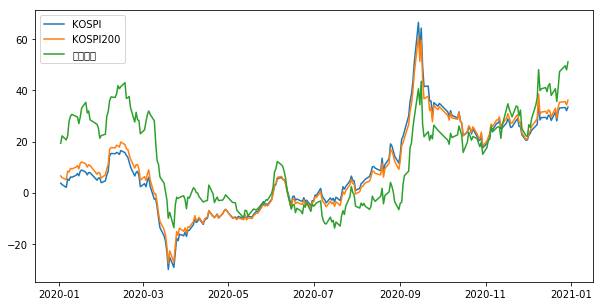

In [212]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_dict.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['prev_rate180'], label=name)
    subplot.legend()
for k, v in ticker_dict.items():
    if (k in ["005930.KS"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
plt.show()

## 차트 - 100기준 수익률

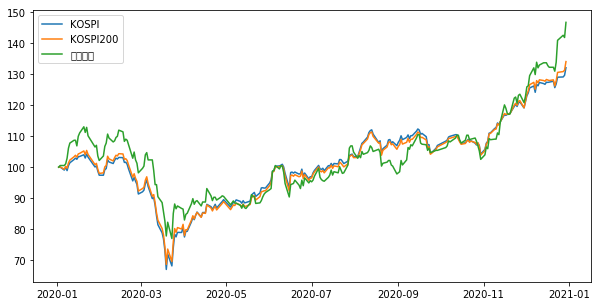

In [224]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_dict.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
for k, v in ticker_dict.items():
    if (k in ["005930.KS"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()
plt.show()

## 차트 - 개별 종목 가격, 이동평균

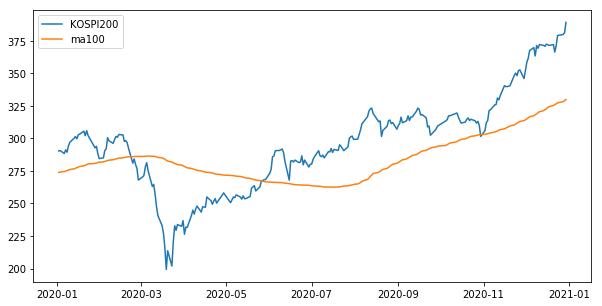

In [225]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "KS200"
ticker_data = std_dict[code]['data']
subplot.plot(ticker_data['Close'], label=std_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
#subplot.plot(ticker_data['ma25'], label='ma25')
#subplot.plot(ticker_data['ma50'], label='ma50')
subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

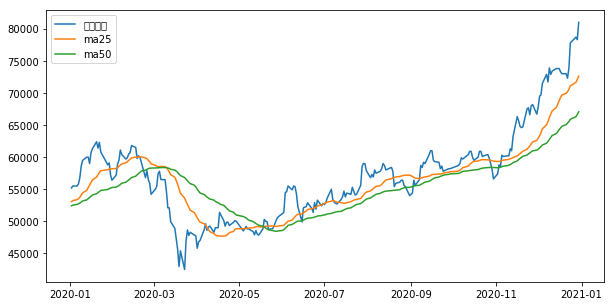

In [226]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_dict[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
2020-01-02,2185,2130,2135,2180,131658,2180,2115,2700,-19.259259,100.000000,2111.0,2144.8,2209.3,2191.4
2020-01-03,2190,2145,2160,2160,107168,2160,2180,2700,-20.000000,99.082569,2121.0,2143.2,2206.8,2192.1


# 자산 관리 - 종목 매수, 매도

In [227]:
class Stock:
    def __init__(self, code):
        self.code = code
        self.stock_name = stock_cache.get_stock_name(code)
        self.count = 0
        self.buy_price = 0
        self.buy_atr20 = 0
        self.highest_price = 0
        self.price = 0 # current price
        self.ammount = 0
        
    def get_profit_percent(self):
        p = (self.price-self.buy_price)/self.buy_price*100
        return round(p, 2)
    
    def get_profit_amount(self):
        return self.amount - self.buy_price*self.count
        
    def buy(self, count, price, atr20):
        self.count += count
        self.buy_price = price
        self.buy_atr20 = atr20
        self.price = price
        self.apply(price)
        
    def sell(self, count, price):
        self.count -= count
        self.price = price
        self.apply(price)
        
    def apply(self, price):
        self.price = price
        if (price > self.highest_price):
            self.highest_price = price
        self.amount = self.count * self.price
        
class Asset:
    def __init__(self, cash):
        self.stocks = { }
        self.cash = cash
        self.total = cash
    
    def get_stock_count(self):
        return len(self.stocks)
    
    def buy(self, code, count, price, atr20):
        stock = self.get_stock(code)
        
        amount = count * price
        self.cash -= amount # TODO cash 부족시
        stock.buy(count, price, atr20)
        self.eval()
        
    def get_buy_count(self, price):
        count = math.floor(self.cash / price)
        return count
    
    def sell(self, code, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return

        stock = self.get_stock(code)
        count = stock.count
        amount = count * price
        stock.sell(count, price)
        self.cash += amount
        
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
    
    def apply(self, code, price):
        if (self.is_stock(code)):
            stock = self.get_stock(code)
            stock.apply(price)
            self.eval()
        
    def get_stock(self, code):
        if code in self.stocks:
            return self.stocks[code]
        else:
            stock = Stock(code)
            self.stocks[code] = stock;
            return stock
        
    def is_stock(self, code):
        if code in self.stocks:
            return True
        return False
        
    def eval(self):
        stock_total = 0
        for k, v in self.stocks.items():
            stock_total += v.amount
        self.total = stock_total + self.cash
        return self.total
    
    def display(self):
        cash_percent = round(self.cash/self.total*100,2)
        print(f"Asset.display(): total={self.total} cash={self.cash} cash_percent={cash_percent}")
        for k, v in self.stocks.items():
            print("    ", "code=", v.code, "stock_name=", v.stock_name, \
                  "count=", v.count, "price=", v.price, "amount=", v.amount, \
                  "highest_price=", v.highest_price, \
                  "profit_percent=", v.get_profit_percent())


In [228]:
code = "005930.KS"
asset = Asset(10000000)
asset.buy(code, 10, 70000, 1000)
asset.apply(code, 80000)
asset.sell(code, 90000)
asset.display()

Asset.display(): total=10200000 cash=10200000 cash_percent=100.0


# 종목 이벤트 이력

In [229]:
UNKNOWN_TREND = 0
DOWN_TREND = -1
UP_TREND = 1
class StockHistory:
    def __init__(self, code):
        self.code = code
        self.name = stock_cache.get_stock_name(code)
        self.trend = UNKNOWN_TREND
        self.event_histories = [ ]

class StockHistoryStore:
    def __init__(self):
        self.stock_histories = { }
        
    def get_stock_history(self, code):
        if code in self.stock_histories:
            return self.stock_histories[code]
        else:
            stock_history = StockHistory(code)
            self.stock_histories[code] = stock_history;
            return stock_history

# 시스템

In [230]:
batch_data = pd.DataFrame()
idx = '2020-01-02'
for k, v in ticker_dict.items():
    copy = v['data'].loc[idx].copy() # ticker_data
    copy['code'] = k
    batch_data = batch_data.append(copy)
batch_filtered_data = batch_data[batch_data.ma25 > batch_data.ma50]
batch_filtered_data.sort_values(by='prev_rate180', ascending=False)

,Adj Close,Close,High,Low,Open,Volume,ata20,atr20,code,ma100,ma25,ma5,ma50,prev_close01,prev_close180,prev_rate180,relative_value,ta,tr
2020-01-02,3020.000000,3020.0,3145.0,2855.0,2860.0,16067989.0,4.395189e+10,284.75,021050.KS,1412.000000,2203.80,2772.0,1709.600000,2830.0,1265.000000,138.735178,100.0,4.852533e+10,290.0
2020-01-02,12000.000000,12000.0,12250.0,11850.0,12100.0,378657.0,6.379474e+09,599.50,007810.KS,7803.550000,10797.60,11080.0,10253.600000,11500.0,5470.000000,119.378428,100.0,4.543884e+09,400.0
2020-01-02,8100.000000,8100.0,8180.0,7960.0,8110.0,1029138.0,2.290944e+10,653.50,003580.KS,5946.650000,8045.60,8006.0,7881.000000,7900.0,4055.000000,99.753391,100.0,8.336018e+09,220.0
2020-01-02,3345.000000,3345.0,3375.0,3180.0,3290.0,2561318.0,1.165883e+10,188.50,002410.KS,1767.150000,2262.80,3221.0,1958.500000,3360.0,1830.000000,82.786885,100.0,8.567609e+09,195.0
2020-01-02,27688.865234,27900.0,28600.0,27700.0,27950.0,658702.0,2.243148e+10,1100.00,000990.KS,17559.000000,22466.00,27060.0,19956.000000,28150.0,15900.000000,75.471698,100.0,1.837779e+10,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02,2000.000000,2000.0,2050.0,1590.0,1622.0,18449634.0,1.855008e+10,386.70,009810.KS,1826.700000,2119.84,2080.4,1830.920000,1648.0,2680.000000,-25.373134,100.0,3.689927e+10,460.0
2020-01-02,1345.000000,1345.0,1350.0,1295.0,1295.0,287232.0,5.096168e+08,55.25,090370.KS,1390.600000,1369.40,1320.0,1354.600000,1310.0,1805.000000,-25.484765,100.0,3.863270e+08,55.0
2020-01-02,11250.000000,11250.0,11550.0,11100.0,11550.0,600262.0,4.993321e+09,575.00,267260.KS,9765.186221,9392.40,10322.0,9240.870391,10850.0,15290.299805,-26.423941,100.0,6.752948e+09,450.0
2020-01-02,8190.000000,8190.0,8240.0,8010.0,8010.0,26036.0,6.994985e+08,307.50,011810.KS,8116.100000,7966.40,8074.0,7872.200000,8060.0,11700.000000,-30.000000,100.0,2.132348e+08,230.0


In [231]:
code = "005930.KS"
idx = '2020-01-02'
ticker_data = ticker_dict[code]['data']
ticker_data.loc[idx]

High              5.600000e+04
Low               5.500000e+04
Open              5.550000e+04
Close             5.520000e+04
Volume            1.299323e+07
Adj Close         5.230561e+04
prev_close01      5.650000e+04
prev_close180     4.625000e+04
prev_rate180      1.935135e+01
relative_value    1.000000e+02
ma5               5.552000e+04
ma25              5.307800e+04
ma50              5.241700e+04
ma100             4.935000e+04
tr                1.000000e+03
atr20             9.850000e+02
ta                7.172262e+11
ata20             7.223392e+11
Name: 2020-01-02 00:00:00, dtype: float64

In [232]:
class LTHM: # LongTrendHighMomentum
    def __init__(self, max_percent=10, cash=100000000): # 1억원
        self.MAX_POSITION_PERCENT = max_percent # 전체 자산 대비 종목별 최대 비중
        self.RISK_PERCENT = 2 # 손실 위험
        self.MIN_TRADING_AMOUNT = 60 * 1000 * 1000 * 1200 # 6백억
        self.MIN_PRICE = 6000 # 6천원 이상
        self.ATR_MULTIPLY = 2 # stop loss=ATR*ATR_MULTIPLY
        self.PROFIT_RESERVE_PERCENT = 10
        self.stock_history_store = StockHistoryStore()
        self.asset = Asset(cash)
        self.data = pd.DataFrame(columns=['total', 'cash'])
        self.action_histories = [ ]
    
    # 모든 종목에 대해 idx row를 합쳐 batch_data 생성
    def make_batch_data(self, idx):
        batch_data = pd.DataFrame()
        for k, v in ticker_dict.items():
            if (idx in v['data'].index):
                copy = v['data'].loc[idx].copy()
                copy['code'] = k
                batch_data = batch_data.append(copy)
        return batch_data
    
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        # 종목 거래 금액, 주가, 이동 평균 filter
        filtered_data = batch_data[\
            (batch_data['ata20'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_PRICE) &\
            (batch_data.ma25 > batch_data.ma50)]
        return filtered_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)
    
    def backtest(self):
        ticker_data = std_dict['KS11']['data'] # idx 가져오기 위해 지수 종목 사용
        for idx, row in ticker_data.iterrows():
            self.apply(idx)
        
        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):       
        # 신규 종목 체크
        if (self.is_available_position()):
            batch_data = self.make_batch_data(idx)
            batch_data = self.filter_batch_data(batch_data)
            batch_data = self.prioritize_batch_data(batch_data)
            #print("LTHM.apply():", "idx=", idx, "batch_data_len=", len(batch_data))
            for idx, row in batch_data.iterrows():
                code = row['code']
                self.apply_stock(code, idx, row)
  
        # 보유 종목 체크
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = ticker_dict[code]['data']
            row = ticker_data.loc[idx]
            self.apply_stock(code, idx, row)

        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))
        
    def apply_stock(self, code, idx, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        self.asset.apply(code, price)
        
        if (not self.asset.is_stock(code) and \
            self.is_ks200_satisfied(idx) and \
            self.is_uptrend(stock_history, idx, row)):
            count = self.get_buy_count(price, atr20)
            if (count > 0):
                action = { "name": "buy", "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_history.name, "count": count, "price": price}
                print("action:", action)
                self.asset.buy(code, count, price, atr20)
                self.asset.display()
                self.action_histories.append(action)
                
        if (self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            count = stock.count
            if (self.is_stop_loss(stock, row) or \
               self.is_profit_reserve(stock, row)):
                self.asset.sell(code, price)
                action = {"name": "sell", \
                          "idx": idx.strftime('%Y-%m-%d'), \
                          "code": code, \
                          "stock_name": stock_history.name, \
                          "count": count, \
                          "price": price, \
                          "buy_price": stock.buy_price, \
                          "profit_percent": stock.get_profit_percent()}
                print("action:", action)
                self.asset.display()
                self.action_histories.append(action)

    def is_ks200_satisfied(self, idx):
        code = "KS200"
        ticker_data = std_dict[code]['data']
        row = ticker_data.loc[idx]
        if (row['Close'] > row['ma100']):
            return True
        return False
    
    # 총자산 대비 위험 비율
    def get_buy_count(self, price, atr20):
        if (not self.is_available_position()):
            return 0
        position_limit = self.get_position_limit() # 포지션 최대 금액
        position_risk_amount = math.floor(self.asset.total * self.RISK_PERCENT / 100) # 포지션 위험 부담 금액
        stop_loss_amount = atr20*self.ATR_MULTIPLY # 주당 위험 부담 금액
        
        # buy count(포지션 크기) 계산
        buy_count = math.floor(position_risk_amount / stop_loss_amount)
        position_amount = buy_count * price
        if (position_amount > position_limit):
            position_amount = position_limit
            buy_count = math.floor(position_amount / price)
        print(f"LTHM.get_buy_count(): buy_count={buy_count} position_amount={position_amount} \
            total={self.asset.total} cash={self.asset.cash} position_limit{position_limit}")
        return buy_count
    
    # 총자산 대비 금액 비율
    def get_buy_count_old(self, price):       
        if (not self.is_available_position()):
            return 0
        position_cash = self.asset.cash / available_position_count
        position_limit = self.asset.total * self.MAX_POSITION_PERCENT / 100
        print("LTHM.get_buy_count():", "position_cash=", position_cash, "position_limit=", position_limit)
        if (position_cash > position_limit):
            position_cash = position_limit
        return math.floor(position_cash / price)
    
    def get_position_limit(self):
        return math.floor(self.asset.total*self.MAX_POSITION_PERCENT/100)
    
    def is_available_position(self):
        if (self.asset.cash/self.asset.total*100 >= self.MAX_POSITION_PERCENT):
            return True
        return False
    
    def is_uptrend(self, stock_history, idx, row):
        if (row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            return True
        return False        

    def is_downtrend(self, stock_history, idx, row):
        if (row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            return True
        return False
    
    def is_stop_loss(self, stock, row):
        price = row['Close']
        if (price < stock.buy_price and ((stock.buy_price-price) > stock.buy_atr20*self.ATR_MULTIPLY)):
            print("LTHM.is_stop_loss():", "code=", stock.code, "stock_name=", stock.stock_name, \
                  "buy_price=", stock.buy_price, "price=", price, "buy_atr20=", stock.buy_atr20)
            return True
        return False

    def is_profit_reserve(self, stock, row):
        price = row['Close']
        if (price < stock.highest_price*(1-self.PROFIT_RESERVE_PERCENT/100)):
            print("LTHM.is_profit_reserve():", "code=", stock.code, "stock_name=", stock.stock_name, \
                  "buy_price=", stock.buy_price, "price=", price, "highest_price=", stock.highest_price)
            return True
        return False
    
    def on_gold_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != UP_TREND and row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "uptrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False
    
    def on_dead_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != DOWN_TREND and row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "downtrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False


## 시스템 - position=1

In [ ]:
system = LTHM(max_percent=100)
system.backtest()
#system.action_histories

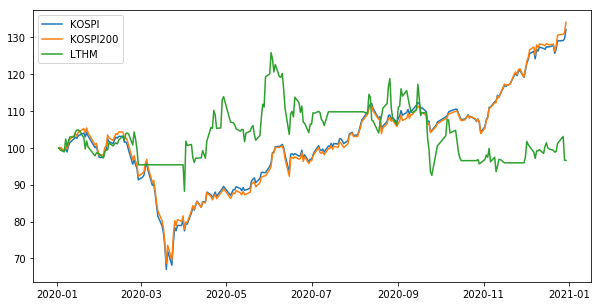

In [76]:
show_chart()

## 시스템 - position=3

In [ ]:
system = LTHM(max_percent=33)
system.backtest()
#system.apply('2020-01-02')
#system.apply('2020-01-03')
#system.action_histories

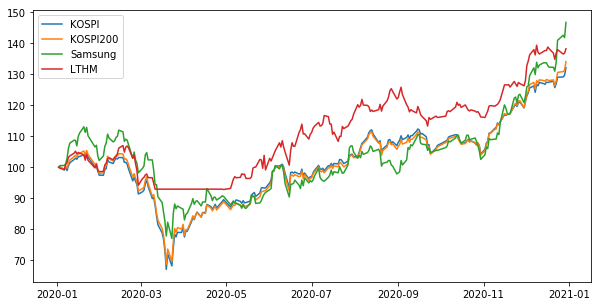

In [31]:
show_chart()

## 시스템 - position=10

In [ ]:
system = LTHM(max_percent=10)
system.backtest()

LTHM.get_buy_count(): buy_count=105 position_amount=10000000             total=100000000 cash=100000000 position_limit10000000
action: {'name': 'buy', 'idx': '2020-01-02', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 105, 'price': 94700.0}
Asset.display(): total=100000000.0 cash=90056500.0 cash_percent=90.06
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 94700.0 amount= 9943500.0 highest_price= 94700.0 profit_percent= 0.0
LTHM.get_buy_count(): buy_count=250 position_amount=10000000             total=100000000.0 cash=90056500.0 position_limit10000000
action: {'name': 'buy', 'idx': '2020-01-02', 'code': '180640.KS', 'stock_name': '한진칼', 'count': 250, 'price': 39950.0}
Asset.display(): total=100000000.0 cash=80069000.0 cash_percent=80.07
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 94700.0 amount= 9943500.0 highest_price= 94700.0 profit_percent= 0.0
     code= 180640.KS stock_name= 한진칼 count= 250 price= 39950.0 amount= 9987500.0 highest_price= 39950.0 prof

LTHM.get_buy_count(): buy_count=304 position_amount=10062641             total=100626411.921875 cash=27898071.125 position_limit10062641
action: {'name': 'buy', 'idx': '2020-01-21', 'code': '035720.KS', 'stock_name': '카카오', 'count': 304, 'price': 33000.0}
Asset.display(): total=100626411.921875 cash=17866071.125 cash_percent=17.75
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 99300.0 amount= 10426500.0 highest_price= 100500.0 profit_percent= 4.86
     code= 180640.KS stock_name= 한진칼 count= 250 price= 40250.0 amount= 10062500.0 highest_price= 42650.0 profit_percent= 0.75
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 61400.0 amount= 11113400.0 highest_price= 62400.0 profit_percent= 11.23
     code= 009150.KS stock_name= 삼성전기 count= 78 price= 133500.0 amount= 10413000.0 highest_price= 136500.0 profit_percent= 4.71
     code= 006400.KS stock_name= 삼성SDI count= 38 price= 275500.0 amount= 10469000.0 highest_price= 275500.0 profit_percent= 2.61
     code= 068270.KS stock

LTHM.is_profit_reserve(): code= 000660.KS stock_name= SK하이닉스 buy_price= 94700.0 price= 92800.0 highest_price= 105000.0
action: {'name': 'sell', 'idx': '2020-02-27', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 105, 'price': 92800.0, 'buy_price': 94700.0, 'profit_percent': -2.01}
Asset.display(): total=105671733.90625 cash=25750571.125 cash_percent=24.37
     code= 180640.KS stock_name= 한진칼 count= 250 price= 65000.0 amount= 16250000.0 highest_price= 65000.0 profit_percent= 62.7
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 56500.0 amount= 10226500.0 highest_price= 62400.0 profit_percent= 2.36
     code= 009150.KS stock_name= 삼성전기 count= 78 price= 131500.0 amount= 10257000.0 highest_price= 146000.0 profit_percent= 3.14
     code= 006400.KS stock_name= 삼성SDI count= 38 price= 312000.0 amount= 11856000.0 highest_price= 343500.0 profit_percent= 16.2
     code= 068270.KS stock_name= 셀트리온 count= 59 price= 169607.84375 amount= 10006862.78125 highest_price= 182352.9375 profit_

Asset.display(): total=103949710.59375 cash=20894628.477539062 cash_percent=20.1
     code= 019170.KS stock_name= 신풍제약 count= 504 price= 20600.0 amount= 10382400.0 highest_price= 20600.0 profit_percent= 0.0
     code= 005690.KS stock_name= 파미셀 count= 438 price= 23700.0 amount= 10380600.0 highest_price= 23700.0 profit_percent= 0.0
     code= 180640.KS stock_name= 한진칼 count= 116 price= 89200.0 amount= 10347200.0 highest_price= 89200.0 profit_percent= 0.0
     code= 026890.KS stock_name= 디피씨 count= 859 price= 12100.0 amount= 10393900.0 highest_price= 12100.0 profit_percent= 0.0
     code= 008350.KS stock_name= 남선알미늄 count= 1565 price= 6640.0 amount= 10391600.0 highest_price= 6640.0 profit_percent= 0.0
     code= 003000.KS stock_name= 부광약품 count= 442 price= 23500.0 amount= 10387000.0 highest_price= 23500.0 profit_percent= 0.0
     code= 336260.KS stock_name= 두산퓨얼셀 count= 727 price= 14284.8447265625 amount= 10385082.116210938 highest_price= 14284.8447265625 profit_percent= 0.0
     code= 01

LTHM.is_profit_reserve(): code= 005690.KS stock_name= 파미셀 buy_price= 23700.0 price= 21550.0 highest_price= 24100.0
action: {'name': 'sell', 'idx': '2020-06-05', 'code': '005690.KS', 'stock_name': '파미셀', 'count': 438, 'price': 21550.0, 'buy_price': 23700.0, 'profit_percent': -9.07}
Asset.display(): total=100273308.88183594 cash=28213700.026367188 cash_percent=28.14
     code= 019170.KS stock_name= 신풍제약 count= 504 price= 20450.0 amount= 10306800.0 highest_price= 21700.0 profit_percent= -0.73
     code= 180640.KS stock_name= 한진칼 count= 116 price= 90900.0 amount= 10544400.0 highest_price= 93300.0 profit_percent= 1.91
     code= 008350.KS stock_name= 남선알미늄 count= 1565 price= 6140.0 amount= 9609100.0 highest_price= 6640.0 profit_percent= -7.53
     code= 003000.KS stock_name= 부광약품 count= 442 price= 24954.544921875 amount= 11029908.85546875 highest_price= 25000.0 profit_percent= 6.19
     code= 035720.KS stock_name= 카카오 count= 199 price= 50800.0 amount= 10109200.0 highest_price= 53400.0 profi

LTHM.is_stop_loss(): code= 008350.KS stock_name= 남선알미늄 buy_price= 6640.0 price= 5650.0 buy_atr20= 316.75
action: {'name': 'sell', 'idx': '2020-06-15', 'code': '008350.KS', 'stock_name': '남선알미늄', 'count': 1565, 'price': 5650.0, 'buy_price': 6640.0, 'profit_percent': -14.91}
Asset.display(): total=116743230.45800781 cash=16985869.219726562 cash_percent=14.55
     code= 019170.KS stock_name= 신풍제약 count= 504 price= 34300.0 amount= 17287200.0 highest_price= 34300.0 profit_percent= 66.5
     code= 003000.KS stock_name= 부광약품 count= 442 price= 32590.908203125 amount= 14405181.42578125 highest_price= 35409.08984375 profit_percent= 38.68
     code= 035720.KS stock_name= 카카오 count= 199 price= 50500.0 amount= 10049500.0 highest_price= 53400.0 profit_percent= -3.07
     code= 207940.KS stock_name= 삼성바이오로직스 count= 16 price= 808000.0 amount= 12928000.0 highest_price= 808000.0 profit_percent= 29.49
     code= 007570.KS stock_name= 일양약품 count= 191 price= 56000.0 amount= 10696000.0 highest_price= 56000.

LTHM.get_buy_count(): buy_count=836 position_amount=12624543             total=126245430.70410156 cash=21395915.739257812 position_limit12624543
action: {'name': 'buy', 'idx': '2020-07-09', 'code': '026890.KS', 'stock_name': '디피씨', 'count': 836, 'price': 15100.0}
Asset.display(): total=126245430.70410156 cash=8772315.739257812 cash_percent=6.95
     code= 035720.KS stock_name= 카카오 count= 199 price= 65600.0 amount= 13054400.0 highest_price= 65600.0 profit_percent= 25.91
     code= 007570.KS stock_name= 일양약품 count= 191 price= 68600.0 amount= 13102600.0 highest_price= 69700.0 profit_percent= 22.5
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 305392.15625 amount= 13131862.71875 highest_price= 312745.09375 profit_percent= 13.69
     code= 006400.KS stock_name= 삼성SDI count= 33 price= 385500.0 amount= 12721500.0 highest_price= 391000.0 profit_percent= 10.62
     code= 036570.KS stock_name= 엔씨소프트 count= 14 price= 945000.0 amount= 13230000.0 highest_price= 995000.0 profit_percent= 16.6

LTHM.get_buy_count(): buy_count=250 position_amount=15809448             total=158094480.7314453 cash=16273451.184570312 position_limit15809448
action: {'name': 'buy', 'idx': '2020-07-21', 'code': '035720.KS', 'stock_name': '카카오', 'count': 250, 'price': 63200.0}
Asset.display(): total=158094480.7314453 cash=473451.1845703125 cash_percent=0.3
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 316666.65625 amount= 13616666.21875 highest_price= 322549.03125 profit_percent= 17.88
     code= 006400.KS stock_name= 삼성SDI count= 33 price= 378500.0 amount= 12490500.0 highest_price= 394000.0 profit_percent= 8.61
     code= 019170.KS stock_name= 신풍제약 count= 391 price= 94900.0 amount= 37105900.0 highest_price= 94900.0 profit_percent= 208.62
     code= 180640.KS stock_name= 한진칼 count= 138 price= 93900.0 amount= 12958200.0 highest_price= 99000.0 profit_percent= 10.34
     code= 026890.KS stock_name= 디피씨 count= 836 price= 17000.0 amount= 14212000.0 highest_price= 18600.0 profit_percent= 12.58
   

LTHM.get_buy_count(): buy_count=61 position_amount=16810105             total=168101059.2626953 cash=33232051.184570312 position_limit16810105
action: {'name': 'buy', 'idx': '2020-07-30', 'code': '285130.KS', 'stock_name': 'SK케미칼', 'count': 61, 'price': 274000.0}
Asset.display(): total=168101059.2626953 cash=16518051.184570312 cash_percent=9.83
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 295588.25 amount= 12710294.75 highest_price= 322549.03125 profit_percent= 10.04
     code= 006400.KS stock_name= 삼성SDI count= 33 price= 385500.0 amount= 12721500.0 highest_price= 394000.0 profit_percent= 10.62
     code= 026890.KS stock_name= 디피씨 count= 836 price= 18850.0 amount= 15758600.0 highest_price= 18850.0 profit_percent= 24.83
     code= 003000.KS stock_name= 부광약품 count= 434 price= 34272.7265625 amount= 14874363.328125 highest_price= 37772.7265625 profit_percent= 6.05
     code= 035720.KS stock_name= 카카오 count= 250 price= 66300.0 amount= 16575000.0 highest_price= 66300.0 profit_perce

LTHM.get_buy_count(): buy_count=214 position_amount=18147200.0             total=193328418.8876953 cash=31108994.512695312 position_limit19332841
action: {'name': 'buy', 'idx': '2020-08-12', 'code': '007570.KS', 'stock_name': '일양약품', 'count': 214, 'price': 84800.0}
Asset.display(): total=193328418.8876953 cash=12961794.512695312 cash_percent=6.7
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 307843.125 amount= 13237254.375 highest_price= 322549.03125 profit_percent= 14.6
     code= 006400.KS stock_name= 삼성SDI count= 33 price= 472500.0 amount= 15592500.0 highest_price= 488000.0 profit_percent= 35.58
     code= 035720.KS stock_name= 카카오 count= 250 price= 70500.0 amount= 17625000.0 highest_price= 74100.0 profit_percent= 11.55
     code= 006120.KS stock_name= SK디스커버리 count= 325 price= 77300.0 amount= 25122500.0 highest_price= 77300.0 profit_percent= 48.37
     code= 006280.KS stock_name= 녹십자 count= 71 price= 301500.0 amount= 21406500.0 highest_price= 301500.0 profit_percent= 26.95


LTHM.is_profit_reserve(): code= 000910.KS stock_name= 유니온 buy_price= 8980.0 price= 8580.0 highest_price= 10050.0
action: {'name': 'sell', 'idx': '2020-08-24', 'code': '000910.KS', 'stock_name': '유니온', 'count': 1869, 'price': 8580.0, 'buy_price': 8980.0, 'profit_percent': -4.45}
Asset.display(): total=187651741.7001953 cash=34226814.51269531 cash_percent=18.24
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 303921.5625 amount= 13068627.1875 highest_price= 322549.03125 profit_percent= 13.14
     code= 035720.KS stock_name= 카카오 count= 250 price= 76000.0 amount= 19000000.0 highest_price= 76000.0 profit_percent= 20.25
     code= 006280.KS stock_name= 녹십자 count= 71 price= 279000.0 amount= 19809000.0 highest_price= 301500.0 profit_percent= 17.47
     code= 035420.KS stock_name= NAVER count= 59 price= 320000.0 amount= 18880000.0 highest_price= 322000.0 profit_percent= 12.48
     code= 019170.KS stock_name= 신풍제약 count= 110 price= 91000.0 amount= 10010000.0 highest_price= 93200.0 profit_p

LTHM.get_buy_count(): buy_count=218 position_amount=20050063             total=200500631.6064453 cash=29059781.606445312 position_limit20050063
action: {'name': 'buy', 'idx': '2020-09-07', 'code': '033270.KS', 'stock_name': '유나이티드제약', 'count': 218, 'price': 91900.0}
Asset.display(): total=200500631.6064453 cash=9025581.606445312 cash_percent=4.5
     code= 035720.KS stock_name= 카카오 count= 250 price= 80400.0 amount= 20100000.0 highest_price= 82400.0 profit_percent= 27.22
     code= 035420.KS stock_name= NAVER count= 59 price= 328500.0 amount= 19381500.0 highest_price= 339000.0 profit_percent= 15.47
     code= 019170.KS stock_name= 신풍제약 count= 110 price= 148500.0 amount= 16335000.0 highest_price= 158000.0 profit_percent= 102.04
     code= 007570.KS stock_name= 일양약품 count= 214 price= 84500.0 amount= 18083000.0 highest_price= 89400.0 profit_percent= -0.35
     code= 285130.KS stock_name= SK케미칼 count= 48 price= 394000.0 amount= 18912000.0 highest_price= 416500.0 profit_percent= 3.96
     co

Asset.display(): total=189047631.6064453 cash=5040495.8955078125 cash_percent=2.67
     code= 035720.KS stock_name= 카카오 count= 250 price= 78000.0 amount= 19500000.0 highest_price= 82400.0 profit_percent= 23.42
     code= 035420.KS stock_name= NAVER count= 59 price= 311000.0 amount= 18349000.0 highest_price= 339000.0 profit_percent= 9.31
     code= 003090.KS stock_name= 대웅 count= 566 price= 36200.0 amount= 20489200.0 highest_price= 38800.0 profit_percent= 9.7
     code= 005690.KS stock_name= 파미셀 count= 880 price= 21150.0 amount= 18612000.0 highest_price= 22700.0 profit_percent= -1.4
     code= 000020.KS stock_name= 동화약품 count= 738 price= 23650.0 amount= 17453700.0 highest_price= 25550.0 profit_percent= 2.6
     code= 019170.KS stock_name= 신풍제약 count= 137 price= 139500.0 amount= 19111500.0 highest_price= 139500.0 profit_percent= 0.0
     code= 037270.KS stock_name= YG PLUS count= 3157 price= 6060.0 amount= 19131420.0 highest_price= 6060.0 profit_percent= 0.0
     code= 285130.KS stock_na

LTHM.get_buy_count(): buy_count=1013 position_amount=19309844             total=193098443.6064453 cash=22745495.895507812 position_limit19309844
action: {'name': 'buy', 'idx': '2020-09-14', 'code': '026890.KS', 'stock_name': '디피씨', 'count': 1013, 'price': 19050.0}
Asset.display(): total=193098443.6064453 cash=3447845.8955078125 cash_percent=1.79
     code= 035720.KS stock_name= 카카오 count= 250 price= 75800.0 amount= 18950000.0 highest_price= 82400.0 profit_percent= 19.94
     code= 000020.KS stock_name= 동화약품 count= 738 price= 26750.0 amount= 19741500.0 highest_price= 26750.0 profit_percent= 16.05
     code= 019170.KS stock_name= 신풍제약 count= 137 price= 146500.0 amount= 20070500.0 highest_price= 153500.0 profit_percent= 5.02
     code= 037270.KS stock_name= YG PLUS count= 3157 price= 6650.0 amount= 20994050.0 highest_price= 6650.0 profit_percent= 9.74
     code= 285130.KS stock_name= SK케미칼 count= 60 price= 346000.0 amount= 20760000.0 highest_price= 349500.0 profit_percent= 8.81
     code=

LTHM.is_profit_reserve(): code= 019170.KS stock_name= 신풍제약 buy_price= 139500.0 price= 166000.0 highest_price= 198000.0
action: {'name': 'sell', 'idx': '2020-09-22', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 137, 'price': 166000.0, 'buy_price': 139500.0, 'profit_percent': 19.0}
Asset.display(): total=194139202.8876953 cash=77059282.88769531 cash_percent=39.69
     code= 000020.KS stock_name= 동화약품 count= 738 price= 25050.0 amount= 18486900.0 highest_price= 26750.0 profit_percent= 8.68
     code= 037270.KS stock_name= YG PLUS count= 3157 price= 6900.0 amount= 21783300.0 highest_price= 7010.0 profit_percent= 13.86
     code= 011000.KS stock_name= 진원생명과학 count= 566 price= 39000.0 amount= 22074000.0 highest_price= 39000.0 profit_percent= 64.56
     code= 093370.KS stock_name= 후성 count= 1666 price= 10550.0 amount= 17576300.0 highest_price= 11500.0 profit_percent= -6.64
     code= 026890.KS stock_name= 디피씨 count= 1013 price= 19250.0 amount= 19500250.0 highest_price= 19700.0 profit_pe

     code= 026890.KS stock_name= 디피씨 count= 1013 price= 20000.0 amount= 20260000.0 highest_price= 20000.0 profit_percent= 4.99
     code= 009830.KS stock_name= 한화솔루션 count= 460 price= 37317.69921875 amount= 17166141.640625 highest_price= 41458.69921875 profit_percent= -9.67
     code= 285130.KS stock_name= SK케미칼 count= 64 price= 305000.0 amount= 19520000.0 highest_price= 305000.0 profit_percent= 0.0
     code= 033270.KS stock_name= 유나이티드제약 count= 153 price= 79500.0 amount= 12163500.0 highest_price= 79500.0 profit_percent= 0.0
     code= 042670.KS stock_name= 두산인프라코어 count= 659 price= 29823.19921875 amount= 19653488.28515625 highest_price= 29823.19921875 profit_percent= 0.0
     code= 035720.KS stock_name= 카카오 count= 278 price= 70600.0 amount= 19626800.0 highest_price= 70600.0 profit_percent= 0.0
     code= 035420.KS stock_name= NAVER count= 68 price= 284500.0 amount= 19346000.0 highest_price= 284500.0 profit_percent= 0.0
LTHM.get_buy_count(): buy_count=110 position_amount=18150000.0   

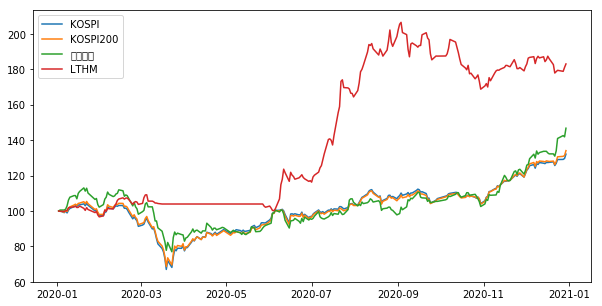

In [191]:
show_chart()

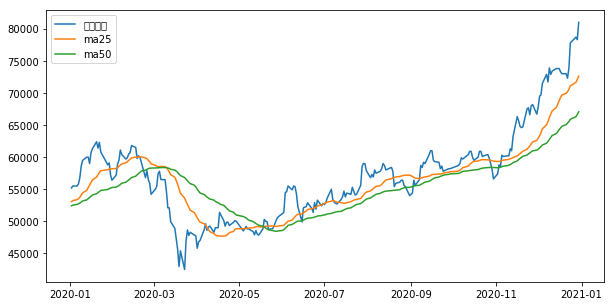

In [59]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_dict[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()